In [3]:
import os
import re
from collections import defaultdict
from random import shuffle
from shutil import copyfile, move, rmtree

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import boto3
import matplotlib.pyplot as plt
import numpy as np
import sagemaker
import tensorflow as tf
import tensorflow_datasets as tfds

## S3 & Sagemaker

In [4]:
s3_bucket = "yang-ml-sagemaker"
s3_key = "weather-classification"

s3 = boto3.client("s3")

s3_downloader = sagemaker.s3.S3Downloader()
s3_uploader = sagemaker.s3.S3Uploader()

In [5]:
sm_session = sagemaker.Session(default_bucket=s3_bucket)

## Raw Data

The raw data stored in the s3 bucket contains JPG images of various weathers--- cloudy, sunrise, rain, etc. The dataset citation is as follows:

> Ajayi, Gbeminiyi (2018), “Multi-class Weather Dataset for Image Classification”, Mendeley Data, V1, doi: 10.17632/4drtyfjtfy.1

We first download the raw data (compressed zip file) from s3 to local and unzip it:

In [6]:
# Create local directory
if os.path.exists(os.path.join(os.path.dirname(os.getcwd()), "raw_data")):
    pass
else:
    os.makedirs(os.path.join(os.path.dirname(os.getcwd()), "raw_data"))

s3_downloader.download(
    s3_uri=f"s3://{s3_bucket}/{s3_key}/raw-data/weather_data.zip",
    local_path=os.path.join(os.path.dirname(os.getcwd()), "raw_data"),
    sagemaker_session=sm_session,
)

In [7]:
raw_data_zip = (
    "/home/ec2-user/SageMaker/weather-classification/raw_data/weather_data.zip"
)

In [8]:
# Unzip
!unzip -q {raw_data_zip} -d {os.path.dirname(raw_data_zip)}

# Remove zip file
os.remove(raw_data_zip)

# Remove macosx
rmtree("/home/ec2-user/SageMaker/weather-classification/raw_data/__MACOSX")

os.listdir(os.path.dirname(raw_data_zip))[:10]

['cloudy171.jpg',
 'rain52.jpg',
 'sunrise60.jpg',
 'shine64.jpg',
 'sunrise35.jpg',
 'sunrise45.jpg',
 'rain68.jpg',
 'sunrise180.jpg',
 'rain64.jpg',
 'rain53.jpg']

### Train-Val-Test Split

Keras has a utility function that generates `tf.data.Dataset` from image files in a directory, which must be in the following structure:

```bash
main_directory/
├── class_a/
│   ├── a_image_1.jpg
│   └── a_image_2.jpg
└── class_b/
    ├── b_image_1.jpg
    └── b_image_2.jpg
```

First, we need to split the images into train-val-test sets, each of which will be a directory as shown above. We first check the distribution of the classes:

In [9]:
image_file_names = os.listdir(os.path.dirname(raw_data_zip))
class_dist = defaultdict(int)
regex_pattern = re.compile(r"([a-zA-Z]+)")  # Match any sequence of letters

for file_name in image_file_names:
    weather = re.search(
        regex_pattern, file_name
    ).group(
        1
    )  # Scan through string looking for the first location where the regular expression pattern produces a match
    class_dist[weather] += 1

# Normalize counts
num_images = len(image_file_names)
for key in class_dist:
    class_dist[key] = round(class_dist[key] / num_images, 6)

print("Total number of images:", num_images)
print("The class distribution:", class_dist)

Total number of images: 1125
The class distribution: defaultdict(<class 'int'>, {'cloudy': 0.266667, 'rain': 0.191111, 'sunrise': 0.317333, 'shine': 0.224889})


It will be better to preserve the class distribution in each of the data sets:

In [10]:
# Create output directories
dir_dict = {}
sets = ["train", "val", "test"]
for dir, set in zip(
    [os.path.join(os.path.dirname(os.getcwd()), "data/" + set) for set in sets], sets
):
    os.makedirs(dir, exist_ok=True)
    dir_dict[set] = dir
    print("Successully create directory", dir)

Successully create directory /home/ec2-user/SageMaker/weather-classification/data/train
Successully create directory /home/ec2-user/SageMaker/weather-classification/data/val
Successully create directory /home/ec2-user/SageMaker/weather-classification/data/test


In [11]:
raw_data_dir = os.path.dirname(raw_data_zip)

for class_label in class_dist:
    # List of all images belonging to 'class_label'
    file_names = [
        file_name
        for file_name in os.listdir(raw_data_dir)
        if file_name.startswith(class_label)
    ]
    # Shuffle image files list in place a few times
    for i in range(5):
        shuffle(file_names)
    # Compute number of files for each set
    num_files = len(file_names)
    num_train = int(num_files * 0.7)  # 70% for training
    num_val = int(num_files * 0.15)  # 15% for validation
    num_test = num_files - num_train - num_val  # Remaining for testing

    for i, file_name in enumerate(file_names):
        # The first batch of files will be used as train
        if i < num_train:
            dest_dir = dir_dict["train"]
        # The next batch will be used as val
        elif i < num_train + num_val:
            dest_dir = dir_dict["val"]
        # The remaining will be test
        else:
            dest_dir = dir_dict["test"]

        dest_file_name = os.path.join(dest_dir, file_name)
        src_file_name = os.path.join(raw_data_dir, file_name)
        copyfile(src_file_name, dest_file_name)

Check that the images across data sets (no duplicates) are unique and sum up to the total number of images:

In [12]:
image_file_names_split = []
for key in dir_dict:
    image_file_names_split += os.listdir(dir_dict[key])

assert sum(np.unique(image_file_names_split) == np.unique(image_file_names)) == 1125

### Re-Structure Directory

Now, we restructure the `data` directory to the structure that `tf.keras.utils.image_dataset_from_directory` expects.

In [13]:
# Create class label subdirectories under each set
for key in dir_dict:
    for class_label in class_dist:
        os.makedirs(os.path.join(dir_dict[key], class_label), exist_ok=True)

In [14]:
for key in dir_dict:
    # List all image files under a data set
    image_files = os.listdir(dir_dict[key])

    # Class labels: cloudy, rain, shine, sunrise
    for class_label in class_dist:
        # List of images files all belonging to the same class
        image_files_for_given_class = [
            image_file
            for image_file in image_files
            if image_file.startswith(class_label)
        ]
        # Directory to move files into e.g. path/to/train/class_label or path/to/val/class_label
        destination_dir_for_given_class = os.path.join(dir_dict[key], class_label)

        # Move operations (plural means list and singular means a single jpg)
        for image_file_for_given_class in image_files_for_given_class:
            image_file_to_move = os.path.join(dir_dict[key], image_file_for_given_class)
            move(src=image_file_to_move, dst=destination_dir_for_given_class)

## Data Ingestion

Load data into memory as `tf.data.Dataset`:

In [16]:
train = tf.keras.utils.image_dataset_from_directory(
    directory=dir_dict["train"],
    labels="inferred",
    label_mode="int",  # An integer label vector must be combined with the 'sparse_categorical_crossentropy' loss
    batch_size=None,  # Do not set batch_size until 'fit' method, which will be tuned as a hyperparameter
    image_size=(256, 256),
    shuffle=True,
)
val = tf.keras.utils.image_dataset_from_directory(
    directory=dir_dict["val"],
    labels="inferred",
    label_mode="int",
    batch_size=None,
    image_size=(256, 256),
    shuffle=True,
)
test = tf.keras.utils.image_dataset_from_directory(
    directory=dir_dict["test"],
    labels="inferred",
    label_mode="int",
    batch_size=None,
    image_size=(256, 256),
    shuffle=False,  # Do not shuffle test set
)

Found 786 files belonging to 4 classes.
Found 167 files belonging to 4 classes.
Found 172 files belonging to 4 classes.


Some sanity checks:

The label is rain


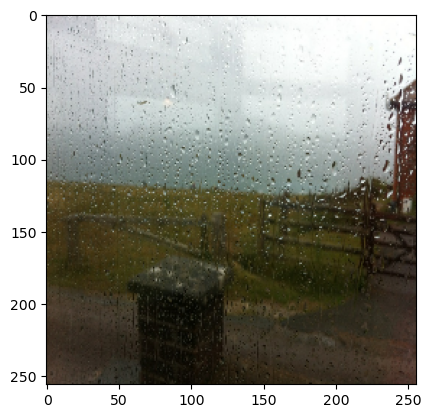

In [17]:
class_labels = ["cloudy", "rain", "shine", "sunrise"]
# Take one training example and plot
for i, example in enumerate(tfds.as_numpy(train)):
    if i == 0:
        X, y = example
    else:
        break

print(f"The label is {class_labels[y]}")
plt.imshow(X.astype("uint8"))

The label is shine


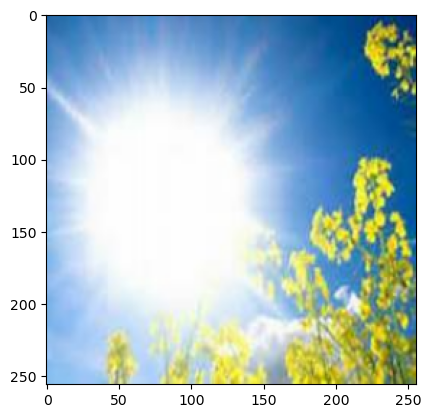

In [18]:
# Take one validation example and plot
for i, example in enumerate(tfds.as_numpy(val)):
    if i == 0:
        X, y = example
    else:
        break

print(f"The label is {class_labels[y]}")
plt.imshow(X.astype("uint8"))

The label is cloudy


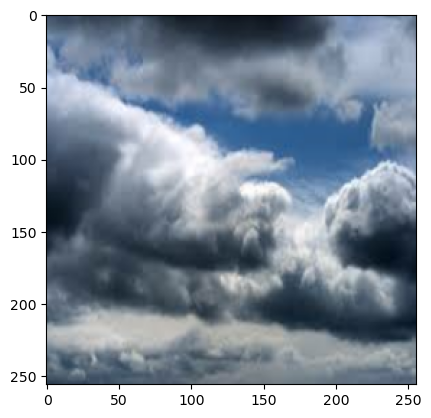

In [19]:
# Take one test example and plot
for i, example in enumerate(tfds.as_numpy(test)):
    if i == 0:
        X, y = example
    else:
        break

print(f"The label is {class_labels[y]}")
plt.imshow(X.astype("uint8"))

### Save DataSets to Disk

Currently, there are bugs related to data augmentation layers where `tf.data.Dataset.load` was introduced, so we will save the data as numpy arrays:

In [22]:
# Create directory for uploading datasets to s3
data_save_paths = {}
for set in ["train", "val", "test"]:
    data_save_paths[set] = os.path.join(
        os.path.dirname(os.getcwd()), f"input-data/{set}"
    )
    os.makedirs(data_save_paths[set])

In [23]:
# Initialize empty lists to store the data
X_train, y_train = [], []
X_val, y_val = [], []
X_test, y_test = [], []

# Iterate over the training dataset and append the data to the lists
for X, y in train:
    X_train.append(X.numpy())
    y_train.append(y.numpy())

# Iterate over the validation dataset and append the data to the lists
for X, y in val:
    X_val.append(X.numpy())
    y_val.append(y.numpy())

# Iterate over the test dataset and append the data to the lists
for X, y in test:
    X_test.append(X.numpy())
    y_test.append(y.numpy())

# Convert the lists to NumPy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [29]:
for key, list_of_arrays in zip(
    data_save_paths, [[X_train, y_train], [X_val, y_val], [X_test, y_test]]
):
    np.save(file=os.path.join(data_save_paths[key], f"X_{key}"), arr=list_of_arrays[0])
    np.save(file=os.path.join(data_save_paths[key], f"y_{key}"), arr=list_of_arrays[1])

In [44]:
data_save_paths

{'train': '/home/ec2-user/SageMaker/weather-classification/input_data/train',
 'val': '/home/ec2-user/SageMaker/weather-classification/input_data/val',
 'test': '/home/ec2-user/SageMaker/weather-classification/input_data/test'}

## Upload to S3

Finally, we upload the datasets to s3:

In [40]:
for key in data_save_paths:
    upload_uri = s3_uploader.upload(
        local_path=data_save_paths[key],
        desired_s3_uri=f"s3://{s3_bucket}/{s3_key}/input-data/{key}",
        sagemaker_session=sm_session,
    )
    print(f"Successfully uploaded dataset to {upload_uri}")

Successfully uploaded dataset to s3://yang-ml-sagemaker/weather-classification/input-data/train
Successfully uploaded dataset to s3://yang-ml-sagemaker/weather-classification/input-data/val
Successfully uploaded dataset to s3://yang-ml-sagemaker/weather-classification/input-data/test


In [41]:
# Check s3 for data
s3_downloader.list(f"s3://{s3_bucket}/{s3_key}/input-data")

['s3://yang-ml-sagemaker/weather-classification/input-data/test/X_test.npy',
 's3://yang-ml-sagemaker/weather-classification/input-data/test/y_test.npy',
 's3://yang-ml-sagemaker/weather-classification/input-data/train/X_train.npy',
 's3://yang-ml-sagemaker/weather-classification/input-data/train/y_train.npy',
 's3://yang-ml-sagemaker/weather-classification/input-data/val/X_val.npy',
 's3://yang-ml-sagemaker/weather-classification/input-data/val/y_val.npy']

## Clean-up

In [46]:
parent_dir = os.path.dirname(os.getcwd())
data = os.path.join(parent_dir, "data")
input_data = os.path.join(parent_dir, "input-data")

!rm -rf {data} {raw_data_dir} {input_data}

In [43]:
s3.close()

del sm_session